# The microprice

An estimator of the fair price, given the state of the order book

KISS

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2970694

# Big question:

What is the fair price, given the bid/ask prices and sizes?

We will call this notion of fair price the microprice.

This notion can be useful to algorithmic traders, HFT, market makers, etc...

# Definitions

The bid, ask, bid size, ask size: $P^b, P^a, Q^b, Q^a$

The mid-price: $$M=\frac{P^b+P^a}{2}$$

The weighted mid-price: $$M=P^b (1-I) +P^a I$$

The imbalance: $$I=\frac{Q_b}{Q_b+Q_a}$$

The bid-ask spread: $$S=(P^a-P^b)$$

In [12]:
import pandas as pd
import numpy as np
%matplotlib inline

In [13]:
def get_df(ticker):
    file1='%s_20110301_20110331.csv'%str(ticker)
    df=pd.read_csv(file1)
    df.columns = ['date','time','bid','bs','ask','as']
    df = df.dropna()
    df['date']=df['date'].astype(float)
    df['time']=df['time'].astype(float)
    df['bid']=df['bid'].astype(float)
    df['ask']=df['ask'].astype(float)
    df['bs']=df['bs'].astype(float)
    df['as']=df['as'].astype(float)
    df['mid']=(df['bid'].astype(float)+df['ask'].astype(float))/2
    df['imb']=df['bs'].astype(float)/(df['bs'].astype(float)+df['as'].astype(float))
    df['wmid']=df['ask'].astype(float)*df['imb']+df['bid'].astype(float)*(1-df['imb'])
    return df

In [32]:
def get_df(ticker):
    file1 = 'binance-futures_quotes_2022_07_16_BTCUSDT.csv'
    df = pd.read_csv(file1, usecols=["timestamp", "bid_price", "bid_amount", "ask_price", "ask_amount"])
    print(df)
    df = df[["timestamp", "bid_price", "bid_amount", "ask_price", "ask_amount"]]
    df.columns = ['time', 'bid', 'bs', 'ask', 'as']
    df = df.dropna()
    df['time'] = df['time'].astype(float)
    df['bid'] = df['bid'].astype(float)
    df['ask'] = df['ask'].astype(float)
    df['bs'] = df['bs'].astype(float)
    df['as'] = df['as'].astype(float)
    df['mid'] = (df['bid'].astype(float)+df['ask'].astype(float))/2
    df['imb'] = df['bs'].astype(
        float)/(df['bs'].astype(float)+df['as'].astype(float))
    df['wmid'] = df['ask'].astype(
        float)*df['imb']+df['bid'].astype(float)*(1-df['imb'])
    return df


In [33]:
data=get_df('BAC')[0:100]
data.head()

                timestamp  ask_amount  ask_price  bid_price  bid_amount
0        1657929600122000       2.238    20822.6    20822.5       0.050
1        1657929601577000       0.103    20821.1    20821.0       0.435
2        1657929602584000       0.103    20821.1    20821.0       0.341
3        1657929602872000       0.103    20821.1    20820.8       0.004
4        1657929602930000       0.103    20821.1    20820.8       0.003
...                   ...         ...        ...        ...         ...
2013060  1658015999810000       1.739    21183.6    21183.5       2.098
2013061  1658015999846000       1.716    21183.6    21183.5       2.098
2013062  1658015999879000       1.716    21183.6    21183.5       2.348
2013063  1658015999913000       1.582    21183.6    21183.5       2.263
2013064  1658015999978000       1.457    21183.6    21183.5       1.827

[2013065 rows x 5 columns]


,time,bid,bs,ask,as,mid,imb,wmid
0,1.657930e+15,20822.5,0.050,20822.6,2.238,20822.55,0.021853,20822.502185
1,1.657930e+15,20821.0,0.435,20821.1,0.103,20821.05,0.808550,20821.080855
2,1.657930e+15,20821.0,0.341,20821.1,0.103,20821.05,0.768018,20821.076802
3,1.657930e+15,20820.8,0.004,20821.1,0.103,20820.95,0.037383,20820.811215
4,1.657930e+15,20820.8,0.003,20821.1,0.103,20820.95,0.028302,20820.808491


<AxesSubplot:>

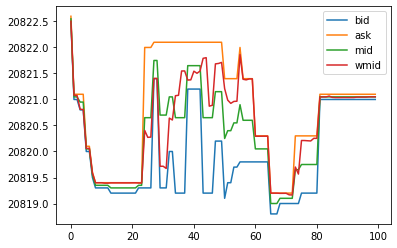

In [34]:
data[['bid','ask','mid','wmid']].plot()

# The mid vs. the weighted mid

The mid-price:
- Not a martingale (Bid-ask bounce)
- Medium frequency signal 
- Doesn't use volume at the best bid and ask prices. 

The weighted mid-price:
- Uses the volume at the best bid and ask prices.
- High frequency signal
- Is quite noisy, particularly when the spread widens to two ticks


# Desirable features of the Micro-Price

 $P_t^{micro}=F(M_t,I_t,S_t) = M_t+ G(I_t,S_t)$ 
- Martingale
- Computationally fast
- Better short term price predictions than the midprice or weighted midprice
- Should work for large tick stocks (like BAC) or small tick stocks (like CVX)

# Outline

1. General definition
2. A discrete Markov model
3. Data analysis
4. Conclusion

# Micro-price definition

Define
\begin{equation*}
P_t^{micro}=\lim_{n\to\infty} P_t^n
\end{equation*}
where the approximating sequence of martingale prices is given by
$$P^n_t=\mathbb{E} \left[  M_{\tau_n} |  I_t,S_t \right] $$

$\tau_1,...,\tau_n$ are (random) times when the mid-price $M_t$ changes
 
The micro-price is the expected mid-price in the distant future
 
In practice, the distant future is well captured by $P_t^6$, the expected mid price after 6 price moves.

# Main result


The $i$-th approximation to the micro-price can be written as
\begin{equation*}
P_t^{n} =  M_t + \sum_{k=1}^{n}g^k(I_t,S_t) 
\end{equation*}
where
$$g^1(I_t,S_t)= \mathbb{E}  \left[  M_{\tau_1} - M_t  | I_t, S_t \right] $$
and
$$
g^{n+1}(I_t,S_t)= \mathbb{E}\left[ g^n(I_{\tau_{1}},S_{\tau_{1}}) | I_{t},S_t\right], \forall j\geq 0
$$
can be computed recursively.

# Finite state Markov chain

- The imbalance takes discrete values $1\leq i_I \leq n$, 
- The spread takes discrete values $1\leq i_S \leq m$
- The mid-price changes takes values in $K =[-0.01 \quad -0.005 \quad 0.005 \quad 0.01]$. 
- Define the state $X_t=(I_t,S_t)$ with discrete values $1\leq i \leq nm$

# Computing $g^1$

The first step approximation to the micro-price 
\begin{align*}
g^1(i) = &  \mathbb{E} \left[M_{\tau_{1}}- M_{t} | X_t= i \right] \\
= {}& \big(1-Q\big)^{-1}R^1\underline{k}
\end{align*}

Where
$$Q_{ij} := \mathbb{P}(M_{t+1}- M_t =0 \wedge X_{t+1}=j | X_t= i)$$
are the transition probabilities for transient states (mid price does not move) 

$$R^1_{ik} := \mathbb{P}(M_{t+1}- M_t =k | X_t = i)$$ are the transition probabilities into absorbing states (mid price does move) 

and $\underline{k}=[-0.01 \quad -0.005 \quad 0.005 \quad 0.01]^T$ 

# Computing $g^{i+1}$


We can compute recursively
\begin{align*}
g^{n+1}=  B g^n
\end{align*}
where $B:=\big(1-Q\big)^{-1}R^2$

and $R^2$ is a new matrix of absorbing states
\begin{align*}
R^2_{ik} := {}& \mathbb{P}(M_{t+1}- M_t \neq 0 \wedge I_{t+1}=k  | I_t = i)
\end{align*}

# Does the micro-price converge?

Yes. But we have to appropriately symmetrize the data.

Technical conditions are available in the paper.

# Data analysis on BAC and CVX

# Estimation

1. On every quote, compute $I_t, S_t, (M_{t+1}-M_t)$, after having discretized the state space
2. Symmetrize the data, by making a copy where $I^2_t=n-I_t, S^2_t=S_t, (M^2_{t+1}-M^2_t)=-(M_{t+1}-M_t)$
3. Estimate transition probability matrices $Q, R^1, R^2$


# Computation

Compute the first micro-price adjustment:
$$p^{1}-M = g^1 = \big(1-Q\big)^{-1}R^1\underline{k}$$
Use our recursive formula to compute the 6th micro-price adjustment:
$$p^{6}-M = g^1+g^2+ \ldots +g^6 = g^1 + B g^1 + \ldots + B^5 g^1 $$
In practice this converges after 6 price moves

In [35]:
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [36]:
def prep_data_sym(T,n_imb,dt,n_spread):
    spread=T.ask-T.bid
    ticksize=np.round(min(spread.loc[spread>0])*100)/100
    T.spread=T.ask-T.bid
    # adds the spread and mid prices
    T['spread']=np.round((T['ask']-T['bid'])/ticksize)*ticksize
    T['mid']=(T['bid']+T['ask'])/2
    #filter out spreads >= n_spread
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    T['imb']=T['bs']/(T['bs']+T['as'])
    #discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False)
    T['next_mid']=T['mid'].shift(-dt)
    #step ahead state variables
    T['next_spread']=T['spread'].shift(-dt)
    T['next_time']=T['time'].shift(-dt)
    T['next_imb_bucket']=T['imb_bucket'].shift(-dt)
    # step ahead change in price
    T['dM']=np.round((T['next_mid']-T['mid'])/ticksize*2)*ticksize/2
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM>=-ticksize*1.1)]
    # symetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket']=n_imb-1-T2['imb_bucket']
    T2['next_imb_bucket']=n_imb-1-T2['next_imb_bucket']
    T2['dM']=-T2['dM']
    T2['mid']=-T2['mid']
    T3=pd.concat([T,T2])
    T3.index = pd.RangeIndex(len(T3.index)) 
    return T3,ticksize

In [37]:
def estimate(T):
    no_move=T[T['dM']==0]
    no_move_counts=no_move.pivot_table(index=[ 'next_imb_bucket'], 
                     columns=['spread', 'imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count').unstack()
    Q_counts=np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]),(n_imb,n_imb))
    # loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
        Q_counts=block_diag(Q_counts,Qi)
    #print Q_counts
    move_counts=T[(T['dM']!=0)].pivot_table(index=['dM'], 
                         columns=['spread', 'imb_bucket'], 
                         values='time',
                         fill_value=0, 
                         aggfunc='count').unstack()

    R_counts=np.resize(np.array(move_counts),(n_imb*n_spread,4))
    T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
    for i in range(0,n_imb*n_spread):
        T1[i]=T1[i]/T1[i].sum()
    Q=T1[:,0:(n_imb*n_spread)]
    R1=T1[:,(n_imb*n_spread):]

    K=np.array([-0.01, -0.005, 0.005, 0.01])
    move_counts=T[(T['dM']!=0)].pivot_table(index=['spread','imb_bucket'], 
                     columns=['next_spread', 'next_imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count') #.unstack()

    R2_counts=np.resize(np.array(move_counts),(n_imb*n_spread,n_imb*n_spread))
    T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)

    for i in range(0,n_imb*n_spread):
        T2[i]=T2[i]/T2[i].sum()
    R2=T2[:,(n_imb*n_spread):]
    Q2=T2[:,0:(n_imb*n_spread)]
    G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
    B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)
    
    return G1,B,Q,Q2,R1,R2,K

In [38]:
def plot_Gstar(ticker,G1,B,T):
    G2=np.dot(B,G1)+G1
    G3=G2+np.dot(np.dot(B,B),G1)
    G4=G3+np.dot(np.dot(np.dot(B,B),B),G1)
    G5=G4+np.dot(np.dot(np.dot(np.dot(B,B),B),B),G1)
    G6=G5+np.dot(np.dot(np.dot(np.dot(np.dot(B,B),B),B),B),G1)
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb)*0,label='Mid adj',marker='o')
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb),label='Weighted mid adj',marker='o')
    for i in range(0,n_spread):
        plt.plot(imb,G6[(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick adj",marker='o')
    plt.ylim(-0.005,0.005)
    plt.legend(loc='upper left')
    plt.title(ticker+' adjustments')
    plt.xlabel('Imbalance')
    return G6

# BAC

In [39]:
n_imb=10
n_spread=2
dt=1
data=get_df('BAC') 
ticker='BAC'
pd.set_option('mode.chained_assignment', None)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
T,ticksize=prep_data_sym(data,n_imb,dt,n_spread)

                timestamp  ask_amount  ask_price  bid_price  bid_amount
0        1657929600122000       2.238    20822.6    20822.5       0.050
1        1657929601577000       0.103    20821.1    20821.0       0.435
2        1657929602584000       0.103    20821.1    20821.0       0.341
3        1657929602872000       0.103    20821.1    20820.8       0.004
4        1657929602930000       0.103    20821.1    20820.8       0.003
...                   ...         ...        ...        ...         ...
2013060  1658015999810000       1.739    21183.6    21183.5       2.098
2013061  1658015999846000       1.716    21183.6    21183.5       2.098
2013062  1658015999879000       1.716    21183.6    21183.5       2.348
2013063  1658015999913000       1.582    21183.6    21183.5       2.263
2013064  1658015999978000       1.457    21183.6    21183.5       1.827

[2013065 rows x 5 columns]


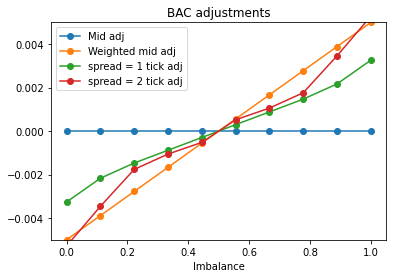

In [40]:
imb=np.linspace(0,1,n_imb)
G1,B,Q,Q2,R1,R2,K=estimate(T)
G6=plot_Gstar(ticker,G1,B,T)

Text(0.5, 0, 'Imbalance')

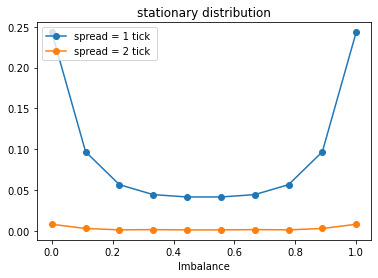

In [41]:
W=np.linalg.matrix_power(B,100)
for i in range(0,n_spread):
    plt.plot(imb,W[0][(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick ",marker='o')
    
plt.legend(loc='upper left')
plt.title('stationary distribution')
plt.xlabel('Imbalance')

# CVX

In [24]:
n_imb=4
n_spread=4
dt=1
data=get_df('CVX') 
ticker='CVX'
T,ticksize=prep_data_sym(data,n_imb,dt,n_spread)
imb=np.linspace(0,1,n_imb)
G1,B,Q,Q2,R1,R2,K=estimate(T)

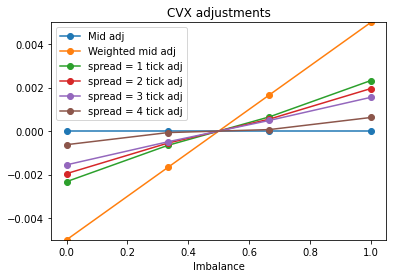

In [25]:
G6=plot_Gstar(ticker,G1,B,T)

Text(0.5, 0, 'Imbalance')

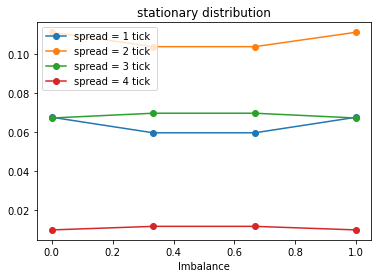

In [26]:
W=np.linalg.matrix_power(B,100)
for i in range(0,n_spread):
    plt.plot(imb,W[0][(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick ",marker='o')
    
plt.legend(loc='upper left')
plt.title('stationary distribution')
plt.xlabel('Imbalance')

# Summary

1. The micro-price is the expected mid-price in the distant future
2. In practice, the distant future is adequately approximated by $\tau^6$ the time of the 6th mid price move
3. Paper provides evidence that the micro-price is a good predictor of future mid prices
3. Micro-price can fit very different microstructures
4. Micro-price is horizon independent
5. Micro-price seems to live between the bid and the ask